## LFP Preprocessing

THIS NOTEBOOK HAS BEEN EDITED FOR THE PREPROESSING OF THE SOCIAL NAVIGATION TASK

These are magics that provide certain functionality. Specifically, if you edit functions that are called in this notebook, the functions are reloaded so the changes propagate here without needing to reload the notebook.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import pickle
from tqdm import tqdm
from IPython.display import clear_output
import warnings 
import scipy

# I only want to see warnings once
warnings.filterwarnings('ignore')

Note: Different users can have different paths. When sharing code with others, you can define username and use it instead of hardcoding paths.

In [3]:
import getpass
username = getpass.getuser()
print(username)

jainp08


Note: If you have installed the LFPAnalysis package in editable form on Minerva, you must append the local path! This is because Minerva requires that you point your package installs away from the local directory for space reasons, but editable packages have to be installed locally.

THE VERSION USED HERE CAN BE FOUND AT https://github.com/gelanat/LFPAnalysis.git

In [4]:
import sys
sys.path.append(f'/hpc/users/{username}/LFPAnalysis/')
if username=='jainp08':
    sys.path.append(f'/hpc/users/{username}/LFPAnalysis_SNT/')

In [5]:
from LFPAnalysis_SNT import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils, SNT_utils

## Setting variables

In [9]:
subj_ids = ['MS008', 'MS009', 'MS019', 'MS020', 'MS030',
            'MS034', 'MS042', 'MS043', 'MS045', 'MS047', 
            'MS048', 'MS050', 'MS051', 'MS052', 'MS053',
            'MS054']
subj_sites = ['MSSM' for _ in subj_ids]
subj_formats = ['edf' for _ in subj_ids]

if username == 'tostag01':
    base_dir = '/sc/arion/projects/OlfMem/tostag01/SocialNav'

if username == 'jainp08':
    base_dir = '/sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG'

In [10]:
load_preproc_data = True
load_reref_data = True

## Pre-process (run 1x): 

In the pre-processing functions below, we: 

1. load the raw data (either a .edf file or a folder of .nlx files) into mne objects for use with the mne toolbox: https://mne.tools/stable/index.html.

2. load the localized electrode names from the .csv or .xlsx file listing their MNI coordinates into the mne object

3. filter and resample as necessary

4. re-reference 

In [11]:
for ix, subj_id in enumerate(subj_ids): 
    site = subj_sites[ix]
    format = subj_formats[ix]
    print(f'Working on subj {subj_id}')
    
    # Set paths
    if format == 'nlx':
        load_path = f'{base_dir}/data/{subj_id}/raw/neural/nlx/'
        save_path = f'{base_dir}/preproc/{subj_id}/LFP/nlx/'
    else:   
        load_path = f'{base_dir}/data/{subj_id}/raw/neural/'
        save_path = f'{base_dir}/preproc/{subj_id}/LFP/'
    
    elec_path = f'{base_dir}/data/{subj_id}/anat/'
    
    # Check if path exists for saving, and if not, make it
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # electrode files could either be csv or excel
    elec_files = glob(f'{elec_path}/*.csv') + glob(f'{elec_path}/*.xlsx')
    # There should really only be one, so grab it with the zero-index 
    elec_file = elec_files[0]
    
    ### Pre-process data
    if load_preproc_data:
        mne_data = mne.io.Raw(f'{save_path}raw_ieeg.fif', preload=True)
        
    else:
        # Make MNE file
        mne_data = lfp_preprocess_utils.make_mne(load_path=load_path, 
                                                 elec_path=elec_file,
                                                 format=format,
                                                 return_data=True,
                                                 site=site,
                                                 check_bad=False) # changed this to not annotate anything as bad 

        # Save this data so that you don't need this step again:
        mne_data.save(f'{save_path}/raw_ieeg.fif', overwrite=True)
        
    ### Bipolar re-reference data
    if load_reref_data:
        mne_data_reref = mne.io.read_raw_fif(f'{save_path}/ieeg_bp.fif', preload=True)
    else:
        # Re-reference neural data
        mne_data_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                                  elec_path=elec_file, 
                                                  method='bipolar', 
                                                  site=site)

        # Save this data so that you don't need this step again:
        mne_data_reref.save(f'{save_path}/ieeg_bp.fif', overwrite=True)

    # Should also save out re-referenced elec_file: 
    elec_data = lfp_preprocess_utils.load_elec(elec_file)
    anode_list = [x.split('-')[0] for x in mne_data_reref.ch_names]
    elec_df = elec_data[elec_data.label.str.lower().isin(anode_list)]
    elec_df['label'] =  elec_df.label.apply(lambda x: [a for a in mne_data_reref.ch_names if str(x).lower() in a.split('-')[0]][0])

    # Add region to the data frame 

    manual_col = [col for col in elec_df.columns if 'manual' in col.lower()][0]
    all_regions = [] 
    for chan_name in elec_df.label.unique():
        elec_region = analysis_utils.select_rois_picks(elec_df, chan_name, manual_col=manual_col)
        all_regions.append(elec_region) 

    elec_df['SNT_region'] = all_regions
    elec_df['hemisphere'] = elec_df.label.apply(lambda x: x[0])

    elec_df.to_csv(f'{save_path}/labels_bp', index=False)
    print(f'Faved to {save_path}/labels_bp')


Working on subj MS008
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS008/LFP/raw_ieeg.fif...
Isotrak not found
    Range : 0 ... 1584499 =      0.000 ...  3168.998 secs
Ready.
Reading 0 ... 1584499  =      0.000 ...  3168.998 secs...
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS008/LFP//ieeg_bp.fif...
    Range : 0 ... 1584499 =      0.000 ...  3168.998 secs
Ready.
Reading 0 ... 1584499  =      0.000 ...  3168.998 secs...
Faved to /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS008/LFP//labels_bp
Working on subj MS009
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS009/LFP/raw_ieeg.fif...
Isotrak not found
    Range : 0 ... 1055187 =      0.000 ...  2110.374 secs
Ready.
Reading 0 ... 1055187  =      0.000 ...  2110.374 secs...
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS009/LFP//ieeg_bp.fif...
    

In [ ]:
# x = pd.read_csv(f'{save_path}/labels_bp')
# x#[x['label'].str.contains('rmoct')]

 - mne_data: a Raw mne object, where the data has been loaded, filtered for line noise, parsed for different data types, and resampled if necessary. 
 
 - mne_data_reref: an mne object containing re-referenced data (either white matter or bipolar)

## NOW look at the data to manually remove channels: 

After bipolar referencing: 

In [ ]:
%matplotlib notebook 

In [ ]:
# Scroll up/down and left/right using your keyboard. CLICK on a channel to turn it 'grey' and mark as a 'bad' channel. 
# If you click a grey channel again it will unmark it. 

mne_data_reref = mne.io.read_raw_fif(f'{save_path}/ieeg_bp.fif', preload=True)
fig = mne_data_reref.plot(start=0, duration=120, n_channels=30, 
                      scalings=mne_data_reref._data.max()/30
                     )

In [ ]:
# ALSO look at the power spectra! 
# You can click on channels here to identify them, and go back to the viz above to mark them as noise if need be

mne_data_reref.compute_psd().plot()

 - mne_dict: a dictionary containing all of your subjects' re-referenced mne data 
 
 - photodiode_dict: a dictionary containing all of your subjects' photodiode data 
 
 - elec_dict: a dictionary containing the paths to your subjects' electrode data 

## Sync behavioral and neural data

Here, we perform a critical step: computing the time offset between the computer that recorded the neural data and the laptop that featured the experiment. 

The function here only requires a **subset** of detected sync signals (i.e. photodiode deflections) to be detected to successfully compute this offset. 

First, you may need to MANUALLY clean the photodiode signal if the recording quality is poor. Load it, plot it, and try to isolate/amplify the pulses. 

Working on subj MS008
1 responses missed for MS008
There are 63 behav syncs detected
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/data/MS008/raw/neural/photodiode.fif...
Isotrak not found
    Range : 0 ... 3245055 =      0.000 ...  3168.999 secs
Ready.
Reading 0 ... 3245055  =      0.000 ...  3168.999 secs...
There are 509 neural syncs detected
Max rval with slope of 1.0000552356653618 and offset of -133.4580524010673
Working on subj MS009
9 responses missed for MS009
There are 63 behav syncs detected
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/data/MS009/raw/neural/photodiode.fif...
Isotrak not found
    Range : 0 ... 2161023 =      0.000 ...  2110.374 secs
Ready.
Reading 0 ... 2161023  =      0.000 ...  2110.374 secs...
There are 64 neural syncs detected
Max rval with slope of 0.9998242775329492 and offset of -37.959870045649524
Working on subj MS019
13 responses missed for MS019
There are 63 behav syncs detected
Op

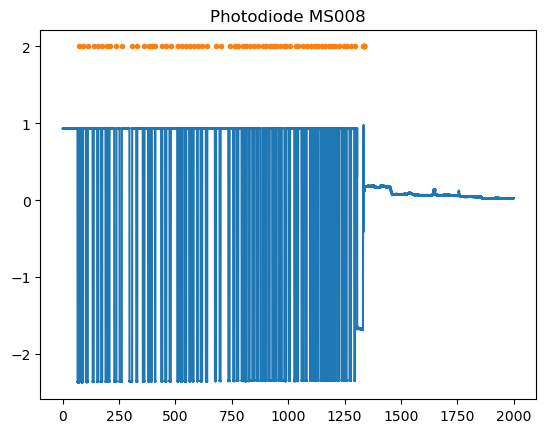

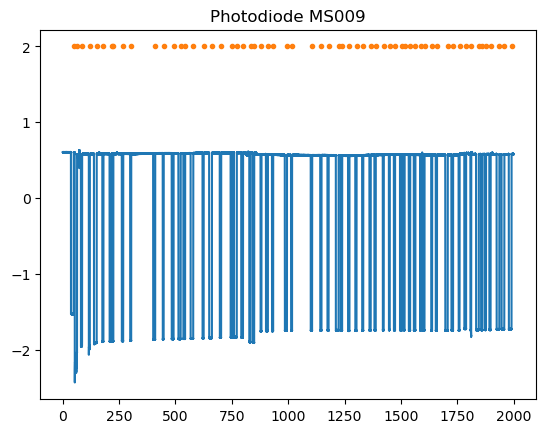

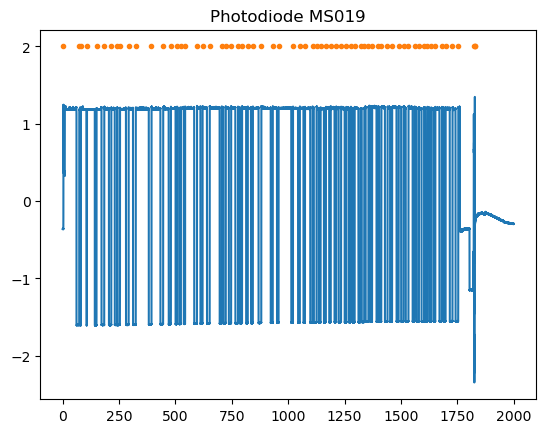

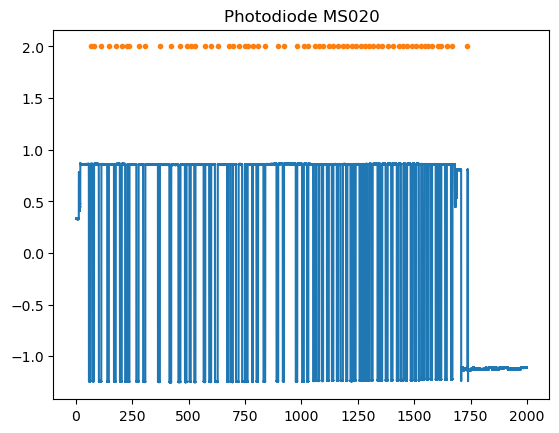

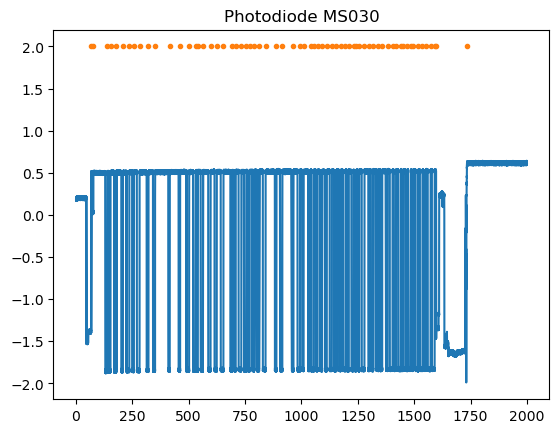

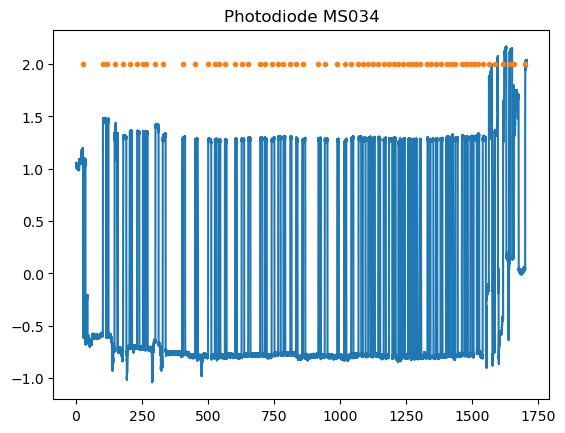

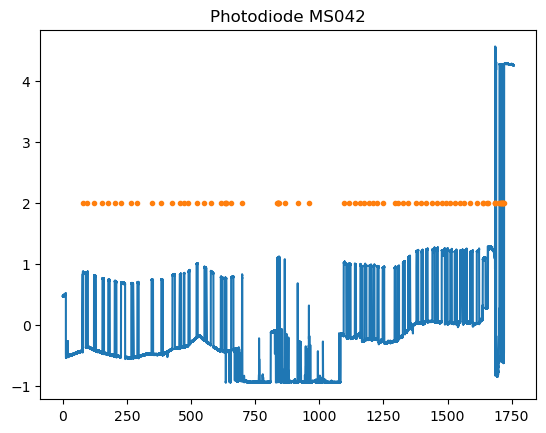

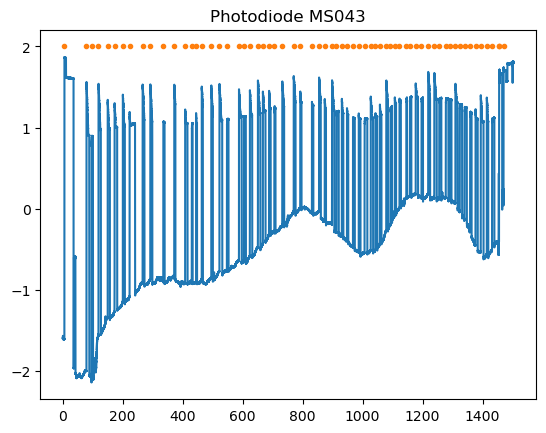

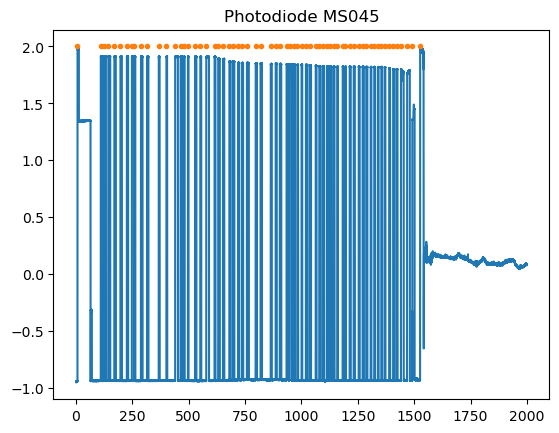

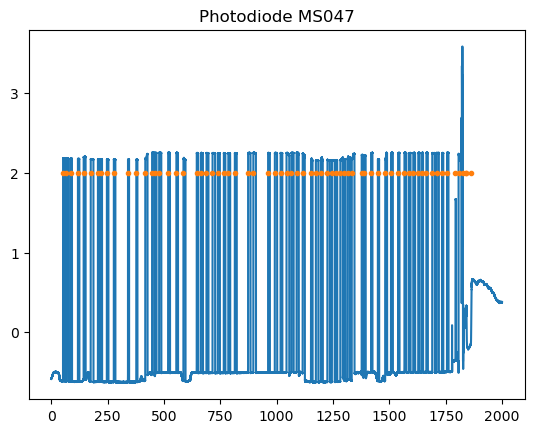

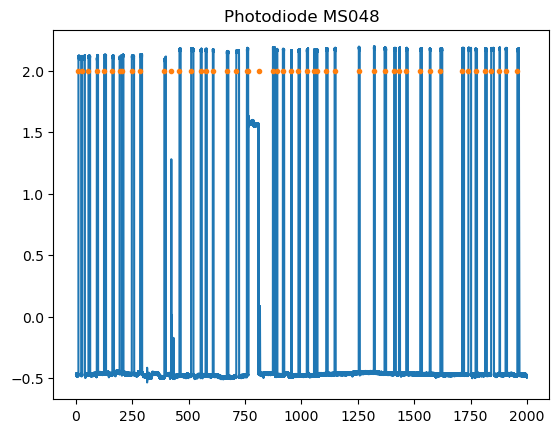

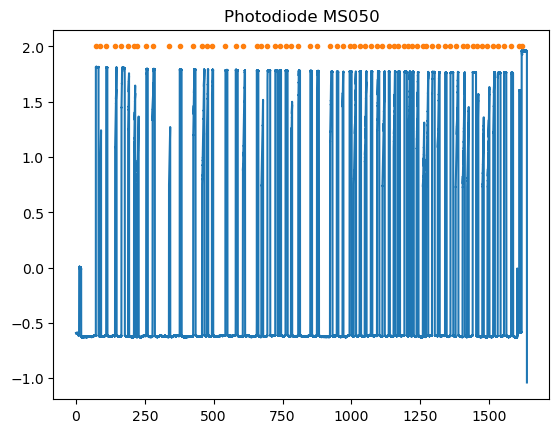

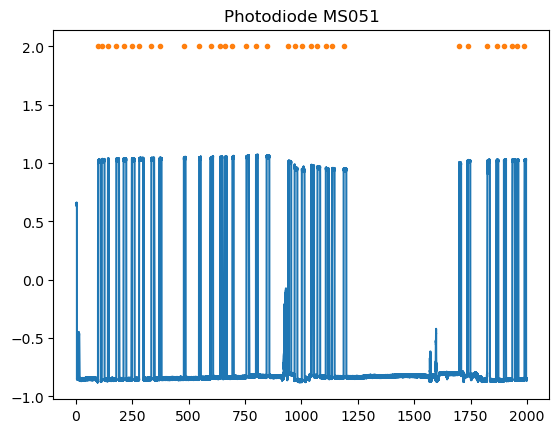

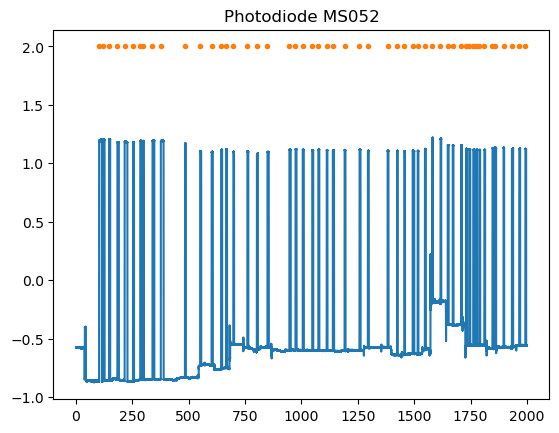

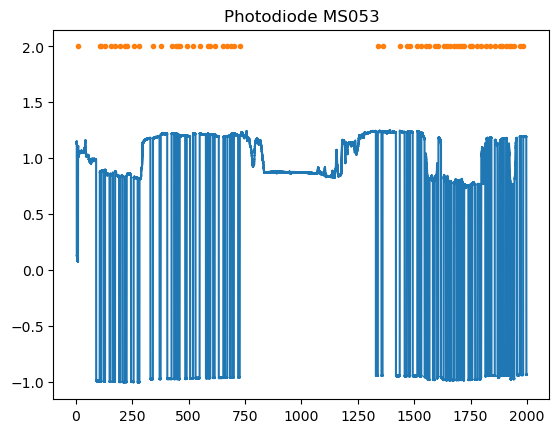

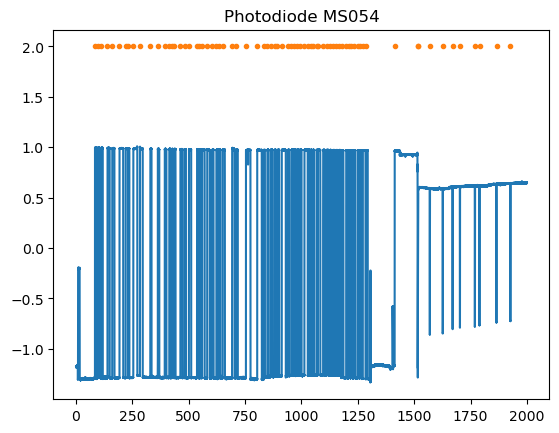

In [12]:
slopes = {f'{x}': 0 for x in subj_ids}
offsets = {f'{x}': 0 for x in subj_ids}

for ix, subj_id in enumerate(subj_ids): 
    site = subj_sites[ix]
    format = subj_formats[ix]
    print(f'Working on subj {subj_id}')
    
    # Set paths
    if format == 'nlx':
        load_path = f'{base_dir}/data/{subj_id}/raw/neural/nlx/'
        save_path = f'{base_dir}/preproc/{subj_id}/LFP/nlx/'
    else:   
        load_path = f'{base_dir}/data/{subj_id}/raw/neural/'
        save_path = f'{base_dir}/preproc/{subj_id}/LFP/'

    behav_path = f'{base_dir}/data/{subj_id}/raw/behav/'
    log_file = glob(f'{behav_path}/*.log')[0]
    time_df = SNT_utils.parse_logfile(log_file)
    time_df.to_csv(f'{base_dir}/preproc/{subj_id}/behav/time_df.csv', index=False)
    missing_responses = time_df[(time_df['decision_trial_start'].notna()) & (time_df['rt'] == 0)]
    print(f'{missing_responses.shape[0]} responses missed for {subj_id}')

    beh_ts = time_df['decision_trial_start'].values
    beh_ts = beh_ts[~np.isnan(beh_ts)]
    print(f'There are {len(beh_ts)} behav syncs detected')
    
    # Synchronize to the photodiode or whatever your neural sync signal is
    if subj_id == 'MS038':
        photodiode_data = mne.io.read_raw_fif(f'{save_path}clean_photodiode.fif', preload=True)
        photodiode_data._data = photodiode_data._data[:,600000:]
        
        smoothSize=35 
        windSize=20
        height=5.6       
        
    else:
        photodiode_data = mne.io.read_raw_fif(f'{load_path}photodiode.fif', preload=True)
        if subj_id == 'MS034':
            photodiode_data._data = photodiode_data._data[:,:1750000]
        if subj_id == 'MS042':
            photodiode_data._data = photodiode_data._data[:,:1800000]
        if subj_id == 'MS043':
            photodiode_data._data = photodiode_data._data[:,0:1540000]
        if subj_id == 'MS054':
            photodiode_data._data *= -1

        smoothSize=15
        windSize=15
        height=0.3

#     try:
#         slope, offset = sync_utils.synchronize_data(beh_ts, 
#                             photodiode_data, 
#                             smoothSize=11, windSize=15,
#                             height=0.8)
        
#     except Exception:
#         try:
#             print("fast and robust sync failed - trying simple sync now")
#             slope, offset = SNT_utils.synchronize(beh_ts, photodiode_data, subj_id, smoothSize, windSize, height)
#         except Exception as e:
#             raise RuntimeError("Both synchronization methods failed. Please review parameters.") from e
    
    try:
        slope, offset = SNT_utils.synchronize(beh_ts, photodiode_data, subj_id, smoothSize, windSize, height)
    except Exception as e:
        raise RuntimeError("Sync failed. Please review parameters or try another method") from e

    slopes[subj_id] = slope
    offsets[subj_id] = offset

record_file = f'{base_dir}/slope_offset_records.xlsx'
if not os.path.isfile(record_file):
    pd.DataFrame(columns=['subject', 'slope', 'offset']).to_excel(record_file, index=False)
else:
    record_df = pd.read_excel(record_file)
    for ix, subj_id in enumerate(subj_ids):
        if subj_id not in record_df['subject'].tolist():
            record_df.loc[len(record_df)] = [subj_id, slopes[subj_id], offsets[subj_id]]
        else:
            record_df.loc[record_df['subject'] == subj_id, 'slope'] == slopes[subj_id]
            record_df.loc[record_df['subject'] == subj_id, 'offset'] == offsets[subj_id]
            
    record_df_sorted = record_df.copy()
    record_df_sorted.sort_values(by='subject')
    record_df = record_df_sorted
    record_df.to_excel(record_file, index=False)

 - slopes: a dictionary containing the slopes (should be ~ 1) for each subject
 - offsets: a dictionary containing the offsets for each subject

## Load your behavioral data & Epoch

Notes:

I also segment a baseline period for every event of interest.

I apply a buffer period of 1.0 seconds - this will be helpful when we compute spectrograms later.

The IED count for every channel is added to the epoch metadata

In [13]:
record_file = f'{base_dir}/slope_offset_records.xlsx'
record_df = pd.read_excel(record_file)

In [14]:
for ix, subj_id in enumerate(subj_ids): 
    site = subj_sites[ix]
    format = subj_formats[ix]
    slope = record_df[record_df['subject'] == subj_id]['slope'].tolist()[0] # slope = slopes[subj_id][0]
    offset = record_df[record_df['subject'] == subj_id]['offset'].tolist()[0] # offset = offsets[subj_id][0]
    print(f'Working on subj {subj_id} with slope {slope} and offset {offset}')
    
    # Set paths
    if format == 'nlx':
        load_path = f'{base_dir}/data/{subj_id}/raw/neural/nlx/'
        save_path = f'{base_dir}/preproc/{subj_id}/LFP/nlx/'
    else:   
        load_path = f'{base_dir}/data/{subj_id}/raw/neural/'
        save_path = f'{base_dir}/preproc/{subj_id}/LFP/'
    
    behav_path = f'{base_dir}/preproc/{subj_id}/behav/'
    elec_path = f'{base_dir}/data/{subj_id}/anat/'
    
    choice_file = glob(f'{behav_path}choice_df_all.csv')[0]
    log_file = glob(f'{behav_path}time_df.csv')[0]
    choice_df = pd.read_csv(choice_file)
    time_df = pd.read_csv(log_file)
    
    buf = 1.0 # this is the buffer before and after that we use to limit edge effects for TFRs

    IED_args = {'peak_thresh':5,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

    # Define epochs of interest according to timestamps from behavior df 
    epochs_list = ['options_slide', 'decision_time', 'narration_slide', 'ITI']
    behav_times = {f'{x}': [] for x in epochs_list}
    behav_times['baseline'] = time_df['decision_trial_start'].dropna().tolist()
    behav_times['decision_time'] = time_df['choice_start'].dropna().tolist()
    behav_times['ITI'] = time_df['choice_start'].dropna().tolist()
    behav_times['narration_slide'] = time_df['space_press_time'].dropna().tolist()


    # Create a dictionary with your event name (matching your dataframe), and the time-window for the event
    evs = {'decision_time': [-1.5, 0], #ChoiceOnset
           'narration_slide': [-1.5, 0], # narration slide
           'ITI': [0, 0.5],  # ITI
           'baseline': [-0.5, 0],  # baseline, few ms before options slide
          }

    buf = 1.0  # this is the buffer before and after that we use to limit edge effects for TFRs
    epochs_all_evs = {f'{x}': np.nan for x in evs}
    
    for event in evs.keys():
        pre = evs[event][0]
        post = evs[event][1]
        fixed_baseline = None

        if event == 'narration_slide' and ((subj_id == 'MS048') or (subj_id == 'MS051')):
            behav_times['narration_slide'] = time_df['non_decision_trial_start'].dropna() - 0.45

        # THE following function will now SAVE out dataframes that indicate IED and artifact time points in your data
        epochs = lfp_preprocess_utils.make_epochs(load_path=f'{save_path}ieeg_bp.fif', 
                                                  slope=slope, offset=offset, 
                                                  behav_name=event, behav_times=behav_times[event],
                                                  ev_start_s=pre, ev_end_s=post, buf_s=buf,
                                                  downsamp_factor=None, IED_args=IED_args, detrend=0)

        epochs_all_evs[event] = epochs
        
        if event in ['decision_time', 'ITI']:
            print(f'Adding metadata for subj {subj_id} to {event} epoch')
            behav_params = ['decision_num', 'char_decision_num', 'scene_num', 'dimension',
               'char_role_num', 'onset', 'button_press', 'decision', 'affil', 'power',
               'reaction_time', 'char', 'decision_axis', 'x', 'y', 'r_current',
               'r_new', 'angle_current', 'angle_new', 'decision_id', 'raw_angle',
               'raw_angle_new', 'cosine_current', 'cosine_new']

            event_metadata = pd.DataFrame(columns=behav_params)
            choice_df_clean = choice_df[choice_df['button_press'] != 0]
            
            for param in behav_params:
                if param in choice_df_clean.columns:
                    event_metadata[param] = choice_df_clean[param].tolist()
                else:
                    print(f"Warning: Parameter {param} not found in choice_df. Filling with NaNs.")
                    event_metadata[param] = np.nan

            # validate metadata alignment
            if len(event_metadata) != len(epochs.events):
                warnings.warn(f"Metadata length ({len(event_metadata)}) does not match " +
                              f"number of epochs ({len(epochs.events)}) for {event}", UserWarning)
                selected_indices = [x+1 for x in epochs.selection]
                decision_num = event_metadata['decision_num'].tolist()
                final_selection = list(set(selected_indices) & set(decision_num))
                event_metadata_extracted = event_metadata[event_metadata['decision_num'].isin(final_selection)].copy()
                epochs_all_evs[event].drop(indices=[x-1 for x in selected_indices if x not in final_selection])
                epochs_all_evs[event].metadata = event_metadata_extracted
            else:            
                epochs_all_evs[event].metadata = event_metadata
            
        epochs_all_evs[event].save(f'{save_path}/{event}-epo.fif', overwrite=True)
        

Working on subj MS008 with slope 1.000055235665362 and offset -133.4580524010673
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS008/LFP/ieeg_bp.fif...
    Range : 0 ... 1584499 =      0.000 ...  3168.998 secs
Ready.
Reading 0 ... 1584499  =      0.000 ...  3168.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 265 samples (0.530 s)



[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   22.7s


Used Annotations descriptions: ['decision_time']
Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 62 events and 1751 original time points ...
0 bad epochs dropped
Adding metadata for subj MS008 to decision_time epoch
Dropped 0 epochs: 
Adding metadata with 24 columns
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS008/LFP/ieeg_bp.fif...
    Range : 0 ... 1584499 =      0.000 ...  3168.998 secs
Ready.
Reading 0 ... 1584499  =      0.000 ...  3168.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   22.1s


Used Annotations descriptions: ['narration_slide']
Not setting metadata
148 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 148 events and 1751 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS008/LFP/ieeg_bp.fif...
    Range : 0 ... 1584499 =      0.000 ...  3168.998 secs
Ready.
Reading 0 ... 1584499  =      0.000 ...  3168.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- U

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   20.8s


Used Annotations descriptions: ['ITI']
Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 62 events and 1251 original time points ...
0 bad epochs dropped
Adding metadata for subj MS008 to ITI epoch
Dropped 0 epochs: 
Adding metadata with 24 columns
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS008/LFP/ieeg_bp.fif...
    Range : 0 ... 1584499 =      0.000 ...  3168.998 secs
Ready.
Reading 0 ... 1584499  =      0.000 ...  3168.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidt

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   22.7s


Used Annotations descriptions: ['baseline']
Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 63 events and 1251 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Working on subj MS009 with slope 0.9998242775329492 and offset -37.95987004564952
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS009/LFP/ieeg_bp.fif...
    Range : 0 ... 1055187 =      0.000 ...  2110.374 secs
Ready.
Reading 0 ... 1055187  =      0.000 ...  2110.374 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.4s


Used Annotations descriptions: ['decision_time']
Not setting metadata
54 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 54 events and 1751 original time points ...
0 bad epochs dropped
Adding metadata for subj MS009 to decision_time epoch
Dropped 4 epochs: 0, 4, 17, 20
Adding metadata with 24 columns
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS009/LFP/ieeg_bp.fif...
    Range : 0 ... 1055187 =      0.000 ...  2110.374 secs
Ready.
Reading 0 ... 1055187  =      0.000 ...  2110.374 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.3s


Used Annotations descriptions: ['narration_slide']
Not setting metadata
51 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 51 events and 1751 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS009/LFP/ieeg_bp.fif...
    Range : 0 ... 1055187 =      0.000 ...  2110.374 secs
Ready.
Reading 0 ... 1055187  =      0.000 ...  2110.374 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upp

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.3s


Used Annotations descriptions: ['ITI']
Not setting metadata
54 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 54 events and 1251 original time points ...
0 bad epochs dropped
Adding metadata for subj MS009 to ITI epoch
Dropped 4 epochs: 0, 4, 17, 20
Adding metadata with 24 columns
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS009/LFP/ieeg_bp.fif...
    Range : 0 ... 1055187 =      0.000 ...  2110.374 secs
Ready.
Reading 0 ... 1055187  =      0.000 ...  2110.374 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transit

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.6s


Used Annotations descriptions: ['baseline']
Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 63 events and 1251 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Working on subj MS019 with slope 1.000180750869814 and offset -4.048653441513906
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS019/LFP/ieeg_bp.fif...
    Range : 0 ... 1659187 =      0.000 ...  3318.374 secs
Ready.
Reading 0 ... 1659187  =      0.000 ...  3318.374 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 H

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.2s


Used Annotations descriptions: ['decision_time']
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 50 events and 1751 original time points ...
0 bad epochs dropped
Adding metadata for subj MS019 to decision_time epoch
Dropped 12 epochs: 0, 4, 8, 9, 10, 11, 16, 18, 22, 26, 33, 44
Adding metadata with 24 columns
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS019/LFP/ieeg_bp.fif...
    Range : 0 ... 1659187 =      0.000 ...  3318.374 secs
Ready.
Reading 0 ... 1659187  =      0.000 ...  3318.374 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband atten

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.1s


Used Annotations descriptions: ['narration_slide']
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 132 events and 1751 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS019/LFP/ieeg_bp.fif...
    Range : 0 ... 1659187 =      0.000 ...  3318.374 secs
Ready.
Reading 0 ... 1659187  =      0.000 ...  3318.374 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- U

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.1s


Used Annotations descriptions: ['ITI']
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 50 events and 1251 original time points ...
0 bad epochs dropped
Adding metadata for subj MS019 to ITI epoch
Dropped 12 epochs: 0, 4, 8, 9, 10, 11, 16, 18, 22, 26, 33, 44
Adding metadata with 24 columns
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS019/LFP/ieeg_bp.fif...
    Range : 0 ... 1659187 =      0.000 ...  3318.374 secs
Ready.
Reading 0 ... 1659187  =      0.000 ...  3318.374 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passb

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.0s


Used Annotations descriptions: ['baseline']
Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 63 events and 1251 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Working on subj MS020 with slope 0.999559753399886 and offset 3.014539028254454
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS020/LFP/ieeg_bp.fif...
    Range : 0 ... 1161624 =      0.000 ...  2323.248 secs
Ready.
Reading 0 ... 1161624  =      0.000 ...  2323.248 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.4s


Used Annotations descriptions: ['decision_time']
Not setting metadata
61 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 61 events and 1751 original time points ...
0 bad epochs dropped
Adding metadata for subj MS020 to decision_time epoch
Adding metadata with 24 columns
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS020/LFP/ieeg_bp.fif...
    Range : 0 ... 1161624 =      0.000 ...  2323.248 secs
Ready.
Reading 0 ... 1161624  =      0.000 ...  2323.248 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwid

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.4s


Used Annotations descriptions: ['narration_slide']
Not setting metadata
133 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 133 events and 1751 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS020/LFP/ieeg_bp.fif...
    Range : 0 ... 1161624 =      0.000 ...  2323.248 secs
Ready.
Reading 0 ... 1161624  =      0.000 ...  2323.248 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- U

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.5s


Used Annotations descriptions: ['ITI']
Not setting metadata
61 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 61 events and 1251 original time points ...
0 bad epochs dropped
Adding metadata for subj MS020 to ITI epoch
Adding metadata with 24 columns
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS020/LFP/ieeg_bp.fif...
    Range : 0 ... 1161624 =      0.000 ...  2323.248 secs
Ready.
Reading 0 ... 1161624  =      0.000 ...  2323.248 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB c

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.6s


Used Annotations descriptions: ['baseline']
Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 63 events and 1251 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Working on subj MS030 with slope 1.013737369939695 and offset 48.26914492235858
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS030/LFP/ieeg_bp.fif...
    Reading extended channel information
    Range : 0 ... 1497561 =      0.000 ...  2995.122 secs
Ready.
Reading 0 ... 1497561  =      0.000 ...  2995.122 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    8.4s


Used Annotations descriptions: ['decision_time']
Not setting metadata
54 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 54 events and 1751 original time points ...
0 bad epochs dropped
Adding metadata for subj MS030 to decision_time epoch
Dropped 7 epochs: 4, 6, 18, 21, 26, 45, 51
Adding metadata with 24 columns
Overwriting existing file.
Overwriting existing file.
    Writing channel names to FIF truncated to 15 characters with remapping
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS030/LFP/ieeg_bp.fif...
    Reading extended channel information
    Range : 0 ... 1497561 =      0.000 ...  2995.122 secs
Ready.
Reading 0 ... 1497561  =      0.000 ...  2995.122 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-do

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    8.1s


Used Annotations descriptions: ['narration_slide']
Not setting metadata
146 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 146 events and 1751 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
    Writing channel names to FIF truncated to 15 characters with remapping
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS030/LFP/ieeg_bp.fif...
    Reading extended channel information
    Range : 0 ... 1497561 =      0.000 ...  2995.122 secs
Ready.
Reading 0 ... 1497561  =      0.000 ...  2995.122 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    7.5s


Used Annotations descriptions: ['ITI']
Not setting metadata
54 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 54 events and 1251 original time points ...
0 bad epochs dropped
Adding metadata for subj MS030 to ITI epoch
Dropped 7 epochs: 4, 6, 18, 21, 26, 45, 51
Adding metadata with 24 columns
Overwriting existing file.
Overwriting existing file.
    Writing channel names to FIF truncated to 15 characters with remapping
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS030/LFP/ieeg_bp.fif...
    Reading extended channel information
    Range : 0 ... 1497561 =      0.000 ...  2995.122 secs
Ready.
Reading 0 ... 1497561  =      0.000 ...  2995.122 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin)

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    7.4s


Used Annotations descriptions: ['baseline']
Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 63 events and 1251 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
    Writing channel names to FIF truncated to 15 characters with remapping
Working on subj MS034 with slope 1.000003327867573 and offset -31.48390681809599
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS034/LFP/ieeg_bp.fif...
    Reading extended channel information
    Range : 0 ... 1458030 =      0.000 ...  2916.060 secs
Ready.
Reading 0 ... 1458030  =      0.000 ...  2916.060 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.8s


Used Annotations descriptions: ['decision_time']
Not setting metadata
53 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 53 events and 1751 original time points ...
0 bad epochs dropped
Adding metadata for subj MS034 to decision_time epoch
Dropped 6 epochs: 0, 2, 3, 8, 12, 38
Adding metadata with 24 columns
Overwriting existing file.
Overwriting existing file.
    Writing channel names to FIF truncated to 15 characters with remapping
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS034/LFP/ieeg_bp.fif...
    Reading extended channel information
    Range : 0 ... 1458030 =      0.000 ...  2916.060 secs
Ready.
Reading 0 ... 1458030  =      0.000 ...  2916.060 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain d

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.7s


Used Annotations descriptions: ['narration_slide']
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 132 events and 1751 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
    Writing channel names to FIF truncated to 15 characters with remapping
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS034/LFP/ieeg_bp.fif...
    Reading extended channel information
    Range : 0 ... 1458030 =      0.000 ...  2916.060 secs
Ready.
Reading 0 ... 1458030  =      0.000 ...  2916.060 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.8s


Used Annotations descriptions: ['ITI']
Not setting metadata
53 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 53 events and 1251 original time points ...
0 bad epochs dropped
Adding metadata for subj MS034 to ITI epoch
Dropped 6 epochs: 0, 2, 3, 8, 12, 38
Adding metadata with 24 columns
Overwriting existing file.
Overwriting existing file.
    Writing channel names to FIF truncated to 15 characters with remapping
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS034/LFP/ieeg_bp.fif...
    Reading extended channel information
    Range : 0 ... 1458030 =      0.000 ...  2916.060 secs
Ready.
Reading 0 ... 1458030  =      0.000 ...  2916.060 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) metho

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.8s


Used Annotations descriptions: ['baseline']
Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 63 events and 1251 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
    Writing channel names to FIF truncated to 15 characters with remapping
Working on subj MS042 with slope 1.016042777043861 and offset 32.21082367531838
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS042/LFP/ieeg_bp.fif...
    Reading extended channel information
    Range : 0 ... 1123061 =      0.000 ...  2246.122 secs
Ready.
Reading 0 ... 1123061  =      0.000 ...  2246.122 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.01

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    5.2s


Used Annotations descriptions: ['decision_time']
Not setting metadata
61 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 61 events and 1751 original time points ...
0 bad epochs dropped
Adding metadata for subj MS042 to decision_time epoch
Dropped 3 epochs: 0, 6, 55
Adding metadata with 24 columns
Overwriting existing file.
Overwriting existing file.
    Writing channel names to FIF truncated to 15 characters with remapping
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS042/LFP/ieeg_bp.fif...
    Reading extended channel information
    Range : 0 ... 1123061 =      0.000 ...  2246.122 secs
Ready.
Reading 0 ... 1123061  =      0.000 ...  2246.122 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (fir

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    6.0s


Used Annotations descriptions: ['narration_slide']
Not setting metadata
139 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 139 events and 1751 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
    Writing channel names to FIF truncated to 15 characters with remapping
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS042/LFP/ieeg_bp.fif...
    Reading extended channel information
    Range : 0 ... 1123061 =      0.000 ...  2246.122 secs
Ready.
Reading 0 ... 1123061  =      0.000 ...  2246.122 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    5.6s


Used Annotations descriptions: ['ITI']
Not setting metadata
61 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 61 events and 1251 original time points ...
0 bad epochs dropped
Adding metadata for subj MS042 to ITI epoch
Dropped 3 epochs: 0, 6, 55
Adding metadata with 24 columns
Overwriting existing file.
Overwriting existing file.
    Writing channel names to FIF truncated to 15 characters with remapping
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS042/LFP/ieeg_bp.fif...
    Reading extended channel information
    Range : 0 ... 1123061 =      0.000 ...  2246.122 secs
Ready.
Reading 0 ... 1123061  =      0.000 ...  2246.122 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hammin

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    5.9s


Used Annotations descriptions: ['baseline']
Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 63 events and 1251 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
    Writing channel names to FIF truncated to 15 characters with remapping
Working on subj MS043 with slope 1.015338386877763 and offset -4.348925668070621
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS043/LFP/ieeg_bp.fif...
    Range : 0 ... 1087405 =      0.000 ...  2174.810 secs
Ready.
Reading 0 ... 1087405  =      0.000 ...  2174.810 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband at

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    5.0s


Used Annotations descriptions: ['decision_time']
Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 62 events and 1751 original time points ...
0 bad epochs dropped
Adding metadata for subj MS043 to decision_time epoch
Adding metadata with 24 columns
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS043/LFP/ieeg_bp.fif...
    Range : 0 ... 1087405 =      0.000 ...  2174.810 secs
Ready.
Reading 0 ... 1087405  =      0.000 ...  2174.810 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwid

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    5.2s


Used Annotations descriptions: ['narration_slide']
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 144 events and 1751 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS043/LFP/ieeg_bp.fif...
    Range : 0 ... 1087405 =      0.000 ...  2174.810 secs
Ready.
Reading 0 ... 1087405  =      0.000 ...  2174.810 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- U

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    5.2s


Used Annotations descriptions: ['ITI']
Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 62 events and 1251 original time points ...
0 bad epochs dropped
Adding metadata for subj MS043 to ITI epoch
Adding metadata with 24 columns
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS043/LFP/ieeg_bp.fif...
    Range : 0 ... 1087405 =      0.000 ...  2174.810 secs
Ready.
Reading 0 ... 1087405  =      0.000 ...  2174.810 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB c

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    5.2s


Used Annotations descriptions: ['baseline']
Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 63 events and 1251 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Working on subj MS045 with slope 1.000001529224676 and offset 13.32436046619726
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS045/LFP/ieeg_bp.fif...
    Reading extended channel information
    Range : 0 ... 1253749 =      0.000 ...  2507.498 secs
Ready.
Reading 0 ... 1253749  =      0.000 ...  2507.498 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    7.0s


Used Annotations descriptions: ['decision_time']
Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 59 events and 1751 original time points ...
0 bad epochs dropped
Adding metadata for subj MS045 to decision_time epoch
Adding metadata with 24 columns
Overwriting existing file.
Overwriting existing file.
    Writing channel names to FIF truncated to 15 characters with remapping
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS045/LFP/ieeg_bp.fif...
    Reading extended channel information
    Range : 0 ... 1253749 =      0.000 ...  2507.498 secs
Ready.
Reading 0 ... 1253749  =      0.000 ...  2507.498 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming windo

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    6.4s


Used Annotations descriptions: ['narration_slide']
Not setting metadata
143 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 143 events and 1751 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
    Writing channel names to FIF truncated to 15 characters with remapping
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS045/LFP/ieeg_bp.fif...
    Reading extended channel information
    Range : 0 ... 1253749 =      0.000 ...  2507.498 secs
Ready.
Reading 0 ... 1253749  =      0.000 ...  2507.498 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    7.4s


Used Annotations descriptions: ['ITI']
Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 59 events and 1251 original time points ...
0 bad epochs dropped
Adding metadata for subj MS045 to ITI epoch
Adding metadata with 24 columns
Overwriting existing file.
Overwriting existing file.
    Writing channel names to FIF truncated to 15 characters with remapping
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS045/LFP/ieeg_bp.fif...
    Reading extended channel information
    Range : 0 ... 1253749 =      0.000 ...  2507.498 secs
Ready.
Reading 0 ... 1253749  =      0.000 ...  2507.498 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passba

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    6.1s


Used Annotations descriptions: ['baseline']
Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 63 events and 1251 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
    Writing channel names to FIF truncated to 15 characters with remapping
Working on subj MS047 with slope 0.9999853492053359 and offset -101.6652532271366
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS047/LFP/ieeg_bp.fif...
    Reading extended channel information
    Range : 0 ... 1705593 =      0.000 ...  3411.186 secs
Ready.
Reading 0 ... 1705593  =      0.000 ...  3411.186 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    8.6s


Used Annotations descriptions: ['decision_time']
Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 60 events and 1751 original time points ...
0 bad epochs dropped
Adding metadata for subj MS047 to decision_time epoch
Dropped 4 epochs: 5, 32, 40, 45
Adding metadata with 24 columns
Overwriting existing file.
Overwriting existing file.
    Writing channel names to FIF truncated to 15 characters with remapping
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS047/LFP/ieeg_bp.fif...
    Reading extended channel information
    Range : 0 ... 1705593 =      0.000 ...  3411.186 secs
Ready.
Reading 0 ... 1705593  =      0.000 ...  3411.186 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    9.4s


Used Annotations descriptions: ['narration_slide']
Not setting metadata
107 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 107 events and 1751 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
    Writing channel names to FIF truncated to 15 characters with remapping
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS047/LFP/ieeg_bp.fif...
    Reading extended channel information
    Range : 0 ... 1705593 =      0.000 ...  3411.186 secs
Ready.
Reading 0 ... 1705593  =      0.000 ...  3411.186 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    9.2s


Used Annotations descriptions: ['ITI']
Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 60 events and 1251 original time points ...
0 bad epochs dropped
Adding metadata for subj MS047 to ITI epoch
Dropped 4 epochs: 5, 32, 40, 45
Adding metadata with 24 columns
Overwriting existing file.
Overwriting existing file.
    Writing channel names to FIF truncated to 15 characters with remapping
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS047/LFP/ieeg_bp.fif...
    Reading extended channel information
    Range : 0 ... 1705593 =      0.000 ...  3411.186 secs
Ready.
Reading 0 ... 1705593  =      0.000 ...  3411.186 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- H

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    9.6s


Used Annotations descriptions: ['baseline']
Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 63 events and 1251 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
    Writing channel names to FIF truncated to 15 characters with remapping
Working on subj MS048 with slope 0.9905465104641955 and offset 795.4234345224513
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS048/LFP/ieeg_bp.fif...
    Reading extended channel information
    Range : 0 ... 1562499 =      0.000 ...  3124.998 secs
Ready.
Reading 0 ... 1562499  =      0.000 ...  3124.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    7.6s


Used Annotations descriptions: ['decision_time']
Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 59 events and 1751 original time points ...
0 bad epochs dropped
Adding metadata for subj MS048 to decision_time epoch
Adding metadata with 24 columns
Overwriting existing file.
Overwriting existing file.
    Writing channel names to FIF truncated to 15 characters with remapping
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS048/LFP/ieeg_bp.fif...
    Reading extended channel information
    Range : 0 ... 1562499 =      0.000 ...  3124.998 secs
Ready.
Reading 0 ... 1562499  =      0.000 ...  3124.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming windo

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    7.6s


Used Annotations descriptions: ['narration_slide']
Not setting metadata
156 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 156 events and 1751 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
    Writing channel names to FIF truncated to 15 characters with remapping
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS048/LFP/ieeg_bp.fif...
    Reading extended channel information
    Range : 0 ... 1562499 =      0.000 ...  3124.998 secs
Ready.
Reading 0 ... 1562499  =      0.000 ...  3124.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    8.0s


Used Annotations descriptions: ['ITI']
Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 59 events and 1251 original time points ...
0 bad epochs dropped
Adding metadata for subj MS048 to ITI epoch
Adding metadata with 24 columns
Overwriting existing file.
Overwriting existing file.
    Writing channel names to FIF truncated to 15 characters with remapping
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS048/LFP/ieeg_bp.fif...
    Reading extended channel information
    Range : 0 ... 1562499 =      0.000 ...  3124.998 secs
Ready.
Reading 0 ... 1562499  =      0.000 ...  3124.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passba

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    7.3s


Used Annotations descriptions: ['baseline']
Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 63 events and 1251 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
    Writing channel names to FIF truncated to 15 characters with remapping
Working on subj MS050 with slope 1.000004690971893 and offset -43.24075682659924
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS050/LFP/ieeg_bp.fif...
    Reading extended channel information
    Range : 0 ... 818874 =      0.000 ...  1637.748 secs
Ready.
Reading 0 ... 818874  =      0.000 ...  1637.748 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.019

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    3.8s


Used Annotations descriptions: ['decision_time']
Not setting metadata
61 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 61 events and 1751 original time points ...
0 bad epochs dropped
Adding metadata for subj MS050 to decision_time epoch
Adding metadata with 24 columns
Overwriting existing file.
Overwriting existing file.
    Writing channel names to FIF truncated to 15 characters with remapping
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS050/LFP/ieeg_bp.fif...
    Reading extended channel information
    Range : 0 ... 818874 =      0.000 ...  1637.748 secs
Ready.
Reading 0 ... 818874  =      0.000 ...  1637.748 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window 

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    3.7s


Used Annotations descriptions: ['narration_slide']
Not setting metadata
145 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 145 events and 1751 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
    Writing channel names to FIF truncated to 15 characters with remapping
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS050/LFP/ieeg_bp.fif...
    Reading extended channel information
    Range : 0 ... 818874 =      0.000 ...  1637.748 secs
Ready.
Reading 0 ... 818874  =      0.000 ...  1637.748 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    3.2s


Used Annotations descriptions: ['ITI']
Not setting metadata
61 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 61 events and 1251 original time points ...
0 bad epochs dropped
Adding metadata for subj MS050 to ITI epoch
Adding metadata with 24 columns
Overwriting existing file.
Overwriting existing file.
    Writing channel names to FIF truncated to 15 characters with remapping
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS050/LFP/ieeg_bp.fif...
    Reading extended channel information
    Range : 0 ... 818874 =      0.000 ...  1637.748 secs
Ready.
Reading 0 ... 818874  =      0.000 ...  1637.748 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    3.3s


Used Annotations descriptions: ['baseline']
Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 63 events and 1251 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
    Writing channel names to FIF truncated to 15 characters with remapping
Working on subj MS051 with slope 0.9951472760867807 and offset 37.38763169182097
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS051/LFP/ieeg_bp.fif...
    Range : 0 ... 2065937 =      0.000 ...  4131.874 secs
Ready.
Reading 0 ... 2065937  =      0.000 ...  4131.874 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband at

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   11.0s


Used Annotations descriptions: ['decision_time']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 41 events and 1751 original time points ...
0 bad epochs dropped
Adding metadata for subj MS051 to decision_time epoch
Adding metadata with 24 columns
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS051/LFP/ieeg_bp.fif...
    Range : 0 ... 2065937 =      0.000 ...  4131.874 secs
Ready.
Reading 0 ... 2065937  =      0.000 ...  4131.874 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwid

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   11.8s


Used Annotations descriptions: ['narration_slide']
Not setting metadata
156 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 156 events and 1751 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS051/LFP/ieeg_bp.fif...
    Range : 0 ... 2065937 =      0.000 ...  4131.874 secs
Ready.
Reading 0 ... 2065937  =      0.000 ...  4131.874 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- U

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   12.0s


Used Annotations descriptions: ['ITI']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 41 events and 1251 original time points ...
0 bad epochs dropped
Adding metadata for subj MS051 to ITI epoch
Adding metadata with 24 columns
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS051/LFP/ieeg_bp.fif...
    Range : 0 ... 2065937 =      0.000 ...  4131.874 secs
Ready.
Reading 0 ... 2065937  =      0.000 ...  4131.874 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB c

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   11.9s


Used Annotations descriptions: ['baseline']
Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 63 events and 1251 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Working on subj MS052 with slope 0.9999868076951971 and offset 9.846945886267719
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS052/LFP/ieeg_bp.fif...
    Range : 0 ... 1437999 =      0.000 ...  2875.998 secs
Ready.
Reading 0 ... 1437999  =      0.000 ...  2875.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 H

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    6.5s


Used Annotations descriptions: ['decision_time']
Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 60 events and 1751 original time points ...
0 bad epochs dropped
Adding metadata for subj MS052 to decision_time epoch
Adding metadata with 24 columns
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS052/LFP/ieeg_bp.fif...
    Range : 0 ... 1437999 =      0.000 ...  2875.998 secs
Ready.
Reading 0 ... 1437999  =      0.000 ...  2875.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwid

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    7.3s


Used Annotations descriptions: ['narration_slide']
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 1751 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS052/LFP/ieeg_bp.fif...
    Range : 0 ... 1437999 =      0.000 ...  2875.998 secs
Ready.
Reading 0 ... 1437999  =      0.000 ...  2875.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upp

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    7.6s


Used Annotations descriptions: ['ITI']
Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 60 events and 1251 original time points ...
0 bad epochs dropped
Adding metadata for subj MS052 to ITI epoch
Adding metadata with 24 columns
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS052/LFP/ieeg_bp.fif...
    Range : 0 ... 1437999 =      0.000 ...  2875.998 secs
Ready.
Reading 0 ... 1437999  =      0.000 ...  2875.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB c

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    7.0s


Used Annotations descriptions: ['baseline']
Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 63 events and 1251 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Working on subj MS053 with slope 0.999557181292875 and offset -6.683276434495724
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS053/LFP/ieeg_bp.fif...
    Range : 0 ... 1588874 =      0.000 ...  3177.748 secs
Ready.
Reading 0 ... 1588874  =      0.000 ...  3177.748 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 H

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.5s


Used Annotations descriptions: ['decision_time']
Not setting metadata
61 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 61 events and 1751 original time points ...
0 bad epochs dropped
Adding metadata for subj MS053 to decision_time epoch
Adding metadata with 24 columns
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS053/LFP/ieeg_bp.fif...
    Range : 0 ... 1588874 =      0.000 ...  3177.748 secs
Ready.
Reading 0 ... 1588874  =      0.000 ...  3177.748 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwid

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.5s


Used Annotations descriptions: ['narration_slide']
Not setting metadata
143 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 143 events and 1751 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS053/LFP/ieeg_bp.fif...
    Range : 0 ... 1588874 =      0.000 ...  3177.748 secs
Ready.
Reading 0 ... 1588874  =      0.000 ...  3177.748 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- U

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.5s


Used Annotations descriptions: ['ITI']
Not setting metadata
61 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 61 events and 1251 original time points ...
0 bad epochs dropped
Adding metadata for subj MS053 to ITI epoch
Adding metadata with 24 columns
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS053/LFP/ieeg_bp.fif...
    Range : 0 ... 1588874 =      0.000 ...  3177.748 secs
Ready.
Reading 0 ... 1588874  =      0.000 ...  3177.748 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB c

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.6s


Used Annotations descriptions: ['baseline']
Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 63 events and 1251 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Working on subj MS054 with slope 0.999985066677363 and offset -12.59776713498957
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS054/LFP/ieeg_bp.fif...
    Range : 0 ... 1163749 =      0.000 ...  2327.498 secs
Ready.
Reading 0 ... 1163749  =      0.000 ...  2327.498 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 H

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    5.2s


Used Annotations descriptions: ['decision_time']
Not setting metadata
61 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 61 events and 1751 original time points ...
0 bad epochs dropped
Adding metadata for subj MS054 to decision_time epoch
Adding metadata with 24 columns
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS054/LFP/ieeg_bp.fif...
    Range : 0 ... 1163749 =      0.000 ...  2327.498 secs
Ready.
Reading 0 ... 1163749  =      0.000 ...  2327.498 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwid

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    5.6s


Used Annotations descriptions: ['narration_slide']
Not setting metadata
143 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 143 events and 1751 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS054/LFP/ieeg_bp.fif...
    Range : 0 ... 1163749 =      0.000 ...  2327.498 secs
Ready.
Reading 0 ... 1163749  =      0.000 ...  2327.498 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- U

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    5.4s


Used Annotations descriptions: ['ITI']
Not setting metadata
61 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 61 events and 1251 original time points ...
0 bad epochs dropped
Adding metadata for subj MS054 to ITI epoch
Adding metadata with 24 columns
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS054/LFP/ieeg_bp.fif...
    Range : 0 ... 1163749 =      0.000 ...  2327.498 secs
Ready.
Reading 0 ... 1163749  =      0.000 ...  2327.498 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB c

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    5.4s


Used Annotations descriptions: ['baseline']
Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 63 events and 1251 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.


## Plot and examine the epochs if you'd like:

In [ ]:
# %matplotlib notebook
# fig = epochs_all_subjs_all_evs['MS007']['feedback_start'].plot(n_epochs=10, n_channels=10)

In [ ]:
# # Need this following line to save the annotations to the epochs object 
# fig.fake_keypress('a')